In [2]:
import sys
sys.path.append("/Users/yash/Desktop/yash-mtp/src/common")
from Model import *
import os
from SilenceRemover import *
from datasets import Dataset
from multiprocess import set_start_method
import numpy as np
import torch
from transformers import  AutoConfig, Wav2Vec2Processor
import librosa
from torch import mps
import torch.nn.functional as F
from sklearn.metrics import classification_report
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import torchaudio



def whatDevice():
    if  torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    return "cpu"
device = whatDevice()
print(f"Device: {device}")
mps.empty_cache()
device = "cpu"

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/transformers/utils/generic.py:260: UserWa

Device: mps


In [33]:
directory = "/Users/yash/Desktop/MTP-2k23-24/Bhashini_Test_Data"
### Intializing models
## for wave2vec2
model_name_or_path = "yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model_wave2vec2 = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)
target_sampling_rate = processor.feature_extractor.sampling_rate
processor.feature_extractor.return_attention_mask = True
label_list  = ['asm', 'ben', 'eng', 'guj', 'hin', 'kan', 'mal', 'mar', 'odi', 'tam', 'tel']
lang2id = {'asm': 0, 'ben': 1, 'eng': 2, 'guj': 3, 'hin': 4, 'kan': 5, 'mal': 6, 'mar': 7, 'odi': 8, 'tam': 9, 'tel': 10,'pun': 10}
id2lang = {0: 'asm', 1: 'ben', 2: 'eng', 3: 'guj', 4: 'hin', 5: 'kan', 6: 'mal', 7: 'mar', 8: 'odi', 9: 'tam', 10: 'tel'}
input_column = 'path'
output_column = 'true_label'
default_path = "dummy-save-folder"
window_size = 32000
hop_length_seconds = 0.5
# Calculate the hop size in samples
hop_size = int(hop_length_seconds * target_sampling_rate)  # Adjust 'sample_rate' as needed

Some weights of the model checkpoint at yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor were not used when initializing Wav2Vec2ForSpeechClassification: ['wav2vec2.encoder.pos_conv_embed.conv.weight_v', 'wav2vec2.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor and are newly initialized: ['wav2vec2.encod

In [34]:
def speech_file_to_array_fn(path: str):
    audio, sr =  librosa.load(path, sr = target_sampling_rate, mono = True)
    clips = librosa.effects.split(audio)
    wav_data = []
    for c in clips:
        data = audio[c[0]: c[1]]
        wav_data.extend(data)
    return wav_data

## function to store the hidden feature representation from the last layer of wave2vec2
def predictFrames(frames):
    features = processor(frames, sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)
    # print(f"shape of the processed input is: {input_values.shape}")
    try:
        with torch.no_grad():
            logits = model_wave2vec2(input_values, attention_mask=attention_mask).logits 
    except Exception as err:
        print(f"Error -> {err} \nSKIPPED! Input Length was: {len(frames[-1])} and features len was : {input_values.shape}")
    return logits

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

def predictOneAudio(path):
    x = speech_file_to_array_fn(path)
    # Generate overlapping frames
    frames = [np.asarray(x[i:i+window_size]).astype('float32') for i in range(0, len(x) - window_size + 1, hop_size)]
    if len(frames[-1]) < 100:
        print(f"Last element has small length of {len(frames[-1])} while it shall be {len(frames[0])}, Dropping!")
        frames.pop()
    logits = predictFrames(frames)
    # Combine logits across frames
    logits = np.vstack(logits)  # Stack logits vertically to combine predictions across frames
    # Take mode to get the final prediction
    final_prediction = np.argmax(np.bincount(np.argmax(logits, axis=-1)))
    # Calculate probabilities using softmax
    prob_distribution = softmax(logits)
    final_probs = np.mean(prob_distribution, axis=0)
    # Format outputs
    outputs = [{"Language": id2lang[i], "Probability": f"{prob * 100:.1f}%"} for i, prob in enumerate(final_probs)]
    return final_prediction, outputs


Original sampling rate is 44100


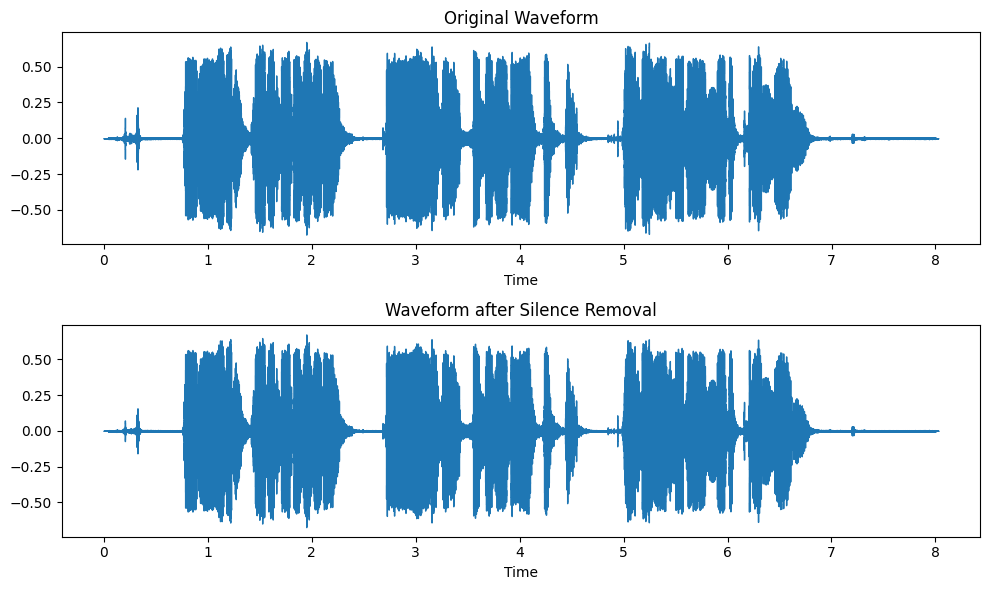

Final predicted lang: mal
   Language  Confidence
0       asm         0.0
1       ben         0.0
2       eng         0.0
3       guj         0.0
4       hin         0.1
5       kan        15.7
6       mal        82.7
7       mar         0.1
8       odi         0.2
9       tam         0.4
10      tel         0.8


In [37]:
def predict(path, target):
    orig_audio, sr = torchaudio.load(path)
    print(f"Original sampling rate is {sr}")
    
    plt.figure(figsize=(10, 6))
    
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(np.array(orig_audio), sr=sr)
    plt.title('Original Waveform')
    
    speech = speech_file_to_array_fn(path)
    
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(np.array(speech), sr=target_sampling_rate)
    plt.title('Waveform after Silence Removal')
    
    plt.tight_layout()
    plt.show()
    
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=target_sampling_rate))
    pred, probs = predictOneAudio(path)
    print(f"Final predicted lang: {id2lang[pred]}")
    df = pd.DataFrame(probs)
    df['Probability'] = df['Probability'].str.rstrip('%').astype(float)  # Convert string percentage to float
    df.columns = ['Language', 'Confidence']  # Rename columns
    print(df)

path= "/Users/yash/Desktop/MTP-2k23-24/Bhashini_Test_Data/mal_ml_2.wav"
target = "Mal"

predict(path, target)